In [18]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score

# Load datasets

In [2]:
pressures_df = pd.read_csv("../data/final_data/pressures_node21.csv").set_index("Timestamp")
flows_df = pd.read_csv("../data/final_data/flows_link21.csv").set_index("Timestamp")

# Split data into train and validation set

## Pressures

In [3]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    pressures_df.drop(["label", "node_21_forecast"], axis=1),
    pressures_df["label"],
    train_size=0.8,
    random_state=29
)

## Flows

In [4]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    flows_df.drop(["label", "link_21_forecast"], axis=1),
    flows_df["label"],
    train_size=0.8,
    random_state=29
)

# Cross validation to select most accurate model

## Pressures

In [5]:
cross_knn_p = cross_val_score(KNeighborsClassifier(), X_train_p, y_train_p, scoring="accuracy", cv=10)
cross_logistic_p = cross_val_score(LogisticRegression(max_iter=200), X_train_p, y_train_p, scoring="accuracy", cv=10)
cross_dtree_p = cross_val_score(DecisionTreeClassifier(), X_train_p, y_train_p, scoring="accuracy", cv=10)
cross_randomf_p = cross_val_score(RandomForestClassifier(), X_train_p, y_train_p, scoring="accuracy", cv=10)

In [6]:
cross_df_p = pd.DataFrame([
    cross_knn_p,
    cross_logistic_p,
    cross_dtree_p,
    cross_randomf_p,
]).T
cross_df_p.columns = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest"]

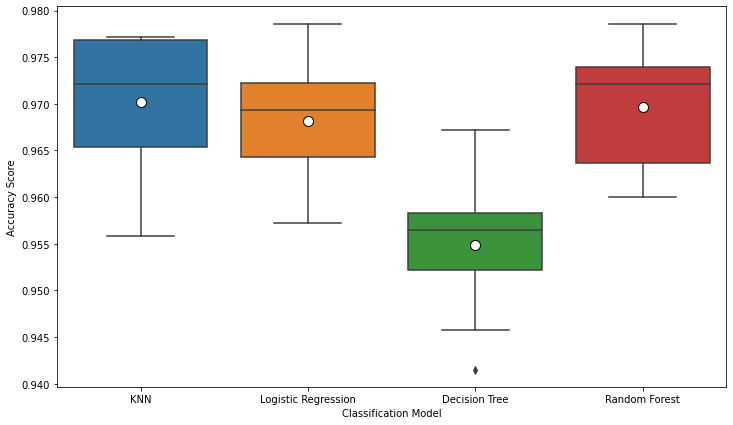

In [7]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=cross_df_p
            .melt(), x="variable", y="value", showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.xlabel("Classification Model")
plt.ylabel("Accuracy Score")
plt.show()

## Flows

In [8]:
cross_knn_f = cross_val_score(KNeighborsClassifier(), X_train_f, y_train_f, scoring="accuracy", cv=10)
cross_logistic_f = cross_val_score(LogisticRegression(max_iter=200), X_train_f, y_train_f, scoring="accuracy", cv=10)
cross_dtree_f = cross_val_score(DecisionTreeClassifier(), X_train_f, y_train_f, scoring="accuracy", cv=10)
cross_randomf_f = cross_val_score(RandomForestClassifier(), X_train_f, y_train_f, scoring="accuracy", cv=10)

In [9]:
cross_df_f = pd.DataFrame([
    cross_knn_f,
    cross_logistic_f,
    cross_dtree_f,
    cross_randomf_f,
]).T
cross_df_f.columns = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest"]

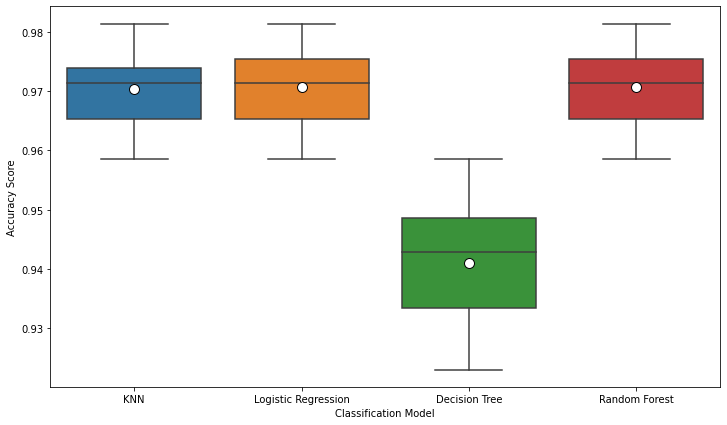

In [10]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=cross_df_f
            .melt(), x="variable", y="value", showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.xlabel("Classification Model")
plt.ylabel("Accuracy Score")
plt.show()

In both cases, Random forest seems to be the most accurate model, if we consider mean accuracy_score

# Analyzing confusion matrix

## Pressures

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1547
         1.0       0.97      0.73      0.84       205

    accuracy                           0.97      1752
   macro avg       0.97      0.86      0.91      1752
weighted avg       0.97      0.97      0.96      1752



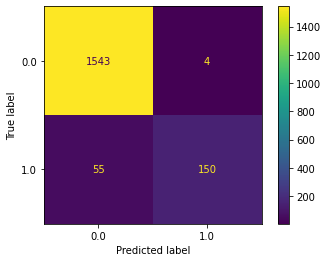

In [11]:
rf_p = RandomForestClassifier()
rf_p.fit(X_train_p, y_train_p)
predictions = rf_p.predict(X_test_p)
print(classification_report(y_pred=predictions, y_true=y_test_p))
cm = confusion_matrix(y_true=y_test_p, y_pred=predictions, labels=rf_p.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf_p.classes_)
disp.plot()

We have a precision of 96% on detecting anomalies (label 1) and a recall of 74% : 74% of all the anomalies presents in the validation set are deteceted

## Flows

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1547
         1.0       1.00      0.71      0.83       205

    accuracy                           0.97      1752
   macro avg       0.98      0.85      0.90      1752
weighted avg       0.97      0.97      0.96      1752



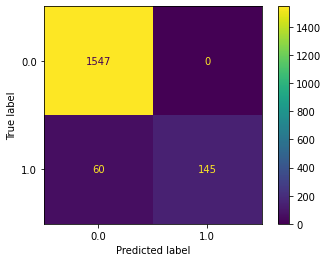

In [12]:
rf_f = RandomForestClassifier()
rf_f.fit(X_train_f, y_train_f)
predictions = rf_f.predict(X_test_f)
print(classification_report(y_pred=predictions, y_true=y_test_f))
cm = confusion_matrix(y_true=y_test_f, y_pred=predictions, labels=rf_f.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf_f.classes_)
disp.plot()

Considering flows, we are more precise (100% precision on detecting anomalies) but we detecte less anomalies (71% against 74% on pressures)

# Importance of SARIMA model to create "difference" feature

## Pressures

Index(['node_21_mean', 'node_21_std', 'node_21_median', 'node_21_min',
       'node_21_max', 'difference'],
      dtype='object')


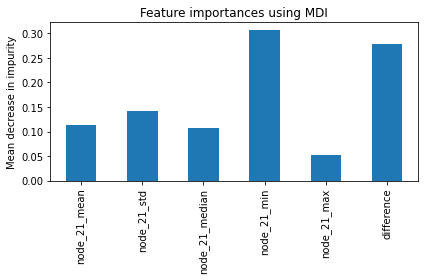

In [13]:
importances = rf_p.feature_importances_
feature_names = pressures_df.drop(["label", "node_21_forecast"], axis=1).columns
print(feature_names)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Flows

Index(['link_21_mean', 'link_21_std', 'link_21_median', 'link_21_min',
       'link_21_max', 'difference'],
      dtype='object')


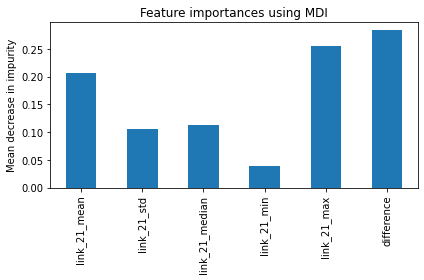

In [14]:
importances = rf_f.feature_importances_
feature_names = flows_df.drop(["label", "link_21_forecast"], axis=1).columns
print(feature_names)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In both cases, the feature *difference* seems to be important on decreasing impurity criterion and then on detceting anomaly

## Trained model performance without "difference"

### Pressures

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1547
         1.0       1.00      0.68      0.81       205

    accuracy                           0.96      1752
   macro avg       0.98      0.84      0.90      1752
weighted avg       0.96      0.96      0.96      1752



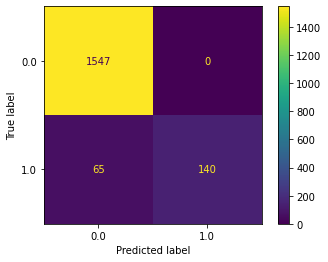

In [15]:
rf_p2 = RandomForestClassifier()
rf_p2.fit(X_train_p.drop("difference", axis=1), y_train_p)
predictions = rf_p2.predict(X_test_p.drop("difference", axis=1))
print(classification_report(y_pred=predictions, y_true=y_test_p))
cm = confusion_matrix(y_true=y_test_p, y_pred=predictions, labels=rf_p2.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf_p2.classes_)
disp.plot()

### Flows

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1547
         1.0       0.99      0.71      0.82       205

    accuracy                           0.96      1752
   macro avg       0.97      0.85      0.90      1752
weighted avg       0.97      0.96      0.96      1752



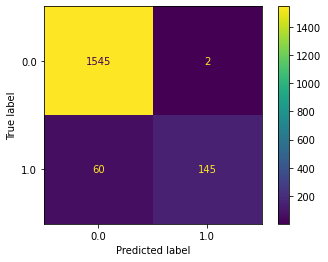

In [16]:
rf_f2 = RandomForestClassifier()
rf_f2.fit(X_train_f.drop("difference", axis=1), y_train_f)
predictions = rf_f2.predict(X_test_f.drop("difference", axis=1))
print(classification_report(y_pred=predictions, y_true=y_test_f))
cm = confusion_matrix(y_true=y_test_f, y_pred=predictions, labels=rf_f2.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf_f2.classes_)
disp.plot()

Using the *difference* feature lets us to imrove the recall metric on pressures validation set (68% to 73%) but we lose a little of precision (100% to 97%). On the flows validation set, using the *difference* feature improves the precision of the model (99% to 100%)

# Saving models

In [19]:
pickle.dump(rf_p, open("../data/models/random_forest_pressures.pickle", "wb"))
pickle.dump(rf_f, open("../data/models/random_forest_flows.pickle", "wb"))